In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("GSAF5.xls")

ELIMINAMOS COLUMNAS QUE NO NECESITAMOS

In [4]:
df = df.drop(columns=['Unnamed: 21','Unnamed: 22','original order','Case Number.1','Case Number','href','href formula','pdf','Source','Name','Age','Injury','Year','Time'])

FUNCIÓN LIMPIEZA

In [5]:
def clean(series):
    series = series.str.upper().str.strip()
    return series.str.title()


ARREGLAMOS NOMBRE COLUMNAS

In [6]:
df.columns = (df.columns.str.strip().str.title())
df = df.rename(columns={'Fatal Y/N': 'Fatal'})

ARREGLAMOS COLUMNA COUNTRY

In [7]:
df["Country"] = clean(df["Country"])
df["Country"] = df["Country"].str.replace(r'[^A-Za-z/\s]', '', regex=True)
df["Country"] = df["Country"].replace({'Usa':'USA'})
df = df.dropna(subset=['Country'])
df = df[df['Country'].map(df['Country'].value_counts()) >= 30]

ARREGLAMOS COLUMNA SEX

In [8]:
df["Sex"] = df["Sex"].replace({'M ': 'M', 'N': 'M', ' M': 'M', 'F ': 'F', 'M x 2': 'M', '.': 'M', 'lli': 'M', 'm':'M'})

ARREGLAMOS COLUMNA FATAL Y/N

In [9]:
df["Fatal"] = df["Fatal"].str.upper()
df["Fatal"] = df["Fatal"].replace({' N':'N','F':'Y', 'M':'N','N ':'N','NQ':'N','Y X 2':'Y','UNKNOWN':'Unknown'})

ARREGLAMOS COLUMNA TYPE

In [10]:
df['Type']=df['Type'].replace({
    ' Provoked':'Provoked','?':'Unknown','Unconfirmed':'Unknown',
    'Under investigation':'Unknown','Unverified':'Unknown'})

ARREGLAMOS COLUMNA STATE

In [11]:
df["State"] = clean(df["State"])

In [12]:
#ARREGLAMOS STATE AUSTRALIA
df["State"] = df["State"].replace({
    'Nsw':'New South Wales',
    'New  South Wales':'New South Wales',
    'New South Ales':'New South Wales',
    'Wa':'Western Australia',
    'Western  Australia':'Western Australia',
    'Westerm Australia':'Western Australia'
    })

In [13]:
#ARREGLAMOS STATE USA
df["State"] = df["State"].replace({
    'Floria':'Florida',
    'Noirth Carolina':'North Carolina',
    'North & South Carolina':'South Carolina',
    'Carolina Coast':'South Carolina'
    })

In [14]:
#ARREGLAMOS STATE SOUTH AFRICA
df["State"] = df["State"].replace({
    'Kwazulu-Natal Between Port Edward And Port St Johns':'Kwazulu-Natal',
    'Kzn':'Kwazulu-Natal',
    'Knz':'Kwazulu-Natal',
    'Eastern Cape  Province':'Eastern Cape Province',
    'Eastern Province':'Eastern Cape Province',
    'Easten Cape Province':'Eastern Cape Province',
    'Western Province':'Western Cape Province'
    })

In [15]:
#ARREGLAMOS STATE NEW ZEALAND
df["State"] = df["State"].replace({
    'South Island?':'South Island',
    'Southland':'South Island',
    'Northlands':'North Island',
    'South Island, Near Karitane North Of Dunedin':'South Island',
    'Off The Coromandel Peninsula, North Island':'North Island',
    'Cook Islans':'Cook Islands',
    'Chatham Islands, East Of New  Zealand':'Chatham Islands'
    })

INICIO LIMPIAR FECHA

In [16]:
def custom_date_parser(date_str):
    try:
        # Intentar convertir a datetime
        return pd.to_datetime(date_str, dayfirst=True)
    except Exception:
        # Si no se puede, devuelvo el texto original sin modificar
        return date_str
df['clean_date'] = df['Date'].apply(custom_date_parser)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19964\1294619701.py:4: UserWarning: Parsing dates in %Y.%m.%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19964\1294619701.py:4: UserWarning: Parsing dates in %m-%d-%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=True)


In [17]:
# Ahora vamos a trabajar con los 876 que quedaron como string
def parse_reported_date(date_str):
    if not isinstance(date_str, str):
        return date_str  # Si no es string, lo dejamos como está
    # Buscamos la palabra "Reported", puede tener espacios antes o después
    if "reported" in date_str.lower():
        # Buscamos una fecha tipo 12-Jul-1952 o 1988
        # Esto pillará fechas como 12-Jul-1952, 14 Jul 1962, 1988, etc.
        match = re.search(r'(\d{1,2}[-\s]?[A-Za-z]{3,9}[-\s]?\d{2,4}|\d{4})', date_str)
        if match:
            possible_date = match.group(1)
            try:
                return pd.to_datetime(possible_date, dayfirst=True)
            except:
                return date_str  # Si no se puede convertir, dejamos el texto original
    return date_str  # Si no contiene "Reported", dejamos el texto original

In [18]:
# Aplicamos esto solo a las filas que quedaron como str
df.loc[df['clean_date'].apply(type) == str, 'clean_date'] = df.loc[df['clean_date'].apply(type) == str, 'clean_date'].apply(parse_reported_date)

In [19]:
def extract_year_as_date(date_str):
    if not isinstance(date_str, str):
        return date_str
    # Buscar año de 4 cifras entre 0001 y 2025
    match = re.search(r'\b(0{0,2}[1-9]\d{0,2}|1\d{3}|20[0-1]\d|202[0-5])\b', date_str)
    if match:
        year = int(match.group(1))
        if 1677 <= year <= 2025:
            return pd.to_datetime(f'{year}-01-01')
        else:
            return pd.NaT  # Año muy antiguo, entonces poner nulo
    return date_str  # Si no se encuentra ningún año válido, devolver texto original

In [20]:
df.loc[df['clean_date'].apply(type) == str, 'clean_date'] = df.loc[df['clean_date'].apply(type) == str, 'clean_date'].apply(extract_year_as_date)

In [21]:
# Cambiar todos los str restantes en 'clean_date' a NaT (que es equivalente a NaN)
df.loc[df['clean_date'].apply(type) == str, 'clean_date'] = pd.NaT

In [22]:
df['clean_date'].apply(type).value_counts()

clean_date
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    6024
<class 'pandas._libs.tslibs.nattype.NaTType'>           57
Name: count, dtype: int64

In [23]:
df = df.drop(columns=['Date'])

In [24]:
df.set_index('clean_date',inplace=True)

c:\Users\Usuario\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [25]:
df.index.name = 'Date'

FINAL LIMPIAR FECHA

ARREGLAMOS COLUNA ACTIVITY

In [26]:
df["Activity"] = clean(df["Activity"])
df["Activity"] = df["Activity"].str.replace(r'[^A-Za-z/\s]', '', regex=True)

In [27]:
df["Activity"].value_counts().head(10)

Activity
Surfing         1106
Swimming         896
Fishing          425
Spearfishing     361
Wading           171
Bathing          142
Diving           117
Snorkeling       114
Standing         109
Scuba Diving      90
Name: count, dtype: int64

In [28]:
df["Activity"] = df["Activity"].replace({
    'Body Surfing':'Body Boarding',
    'Boogie Boarding':'Body Boarding',
    'Surfing Sitting On His Board':'Surfing',
    'Sitting On Surfboard ':'Surfing',
    'Scuba Diving Submerged':'Scuba Diving',
    'Free Diving For Abalone':'Diving For Abalone',
    'SurfSkiing':'Surfski','Surf Skiing':'Surfski',
    'Diving For Abalone Hookah':'Diving For Abalone',
    'Spearfishing Free Diving':'Spearfishing',
    'Spearfishing / Scuba Diving At Surface':'Spearfishing',
    'Spearfishing On Scuba':'Spearfishing',
    'Swimming / Snorkeling ':'Snorkeling'
    })

ARREGLAMOS COLUMNA SPECIES

In [29]:
df["Species"] = clean(df["Species"])

In [30]:
df["Species"] = df["Species"].str.replace(r'[^A-Za-z\s]', '', regex=True)

In [31]:
# Suponiendo que df ya está definido y contiene la columna 'Species' 

pattern = r'\b(\w+)[ -]?[Ss]hark\b'

# Filtrar las filas que cumplen el patrón 

df = df[df["Species"].str.contains(pattern, case=False, na=False, regex=True)]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19964\1869350055.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df["Species"].str.contains(pattern, case=False, na=False, regex=True)]


In [32]:
# Limpiar palabras irrelevantes como "M", "To", "A"
def clean_shark_name(text):
    text = re.sub(r'\b(M|To|A)\b', '', text)     # quitar palabras sueltas
    text = re.sub(r'\s+', ' ', text).strip()     # quitar espacios múltiples
    return text

In [33]:
df["Species_Clean"] = df["Species"].apply(clean_shark_name)

In [34]:
df = df.drop(columns=['Species'])

In [35]:
df = df.rename(columns={'Species_Clean': 'Species'})

In [36]:
df["Species"] = df["Species"].replace({'Shark':'Unidentified Shark','Small Shark':'Unidentified Shark'})

ORDENAR COLUMNAS

In [37]:
column_order = ['Country','State','Location','Species','Activity','Type','Fatal','Sex']
df = df[column_order]

DATA ANALYSIS

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19964\1383357001.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  attacks_per_year = df.resample('Y').size()


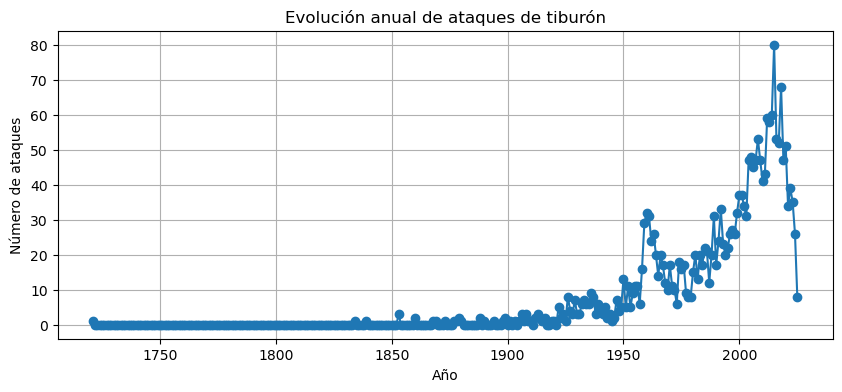

In [ ]:
#Evolución anual de ataques de tiburón

attacks_per_year = df.resample('Y').size()

plt.figure(figsize=(10, 4))
plt.plot(attacks_per_year.index.year, attacks_per_year.values, marker='o')
plt.title('Evolución anual de ataques de tiburón')
plt.xlabel('Año')
plt.ylabel('Número de ataques')
plt.grid(True)
plt.show()

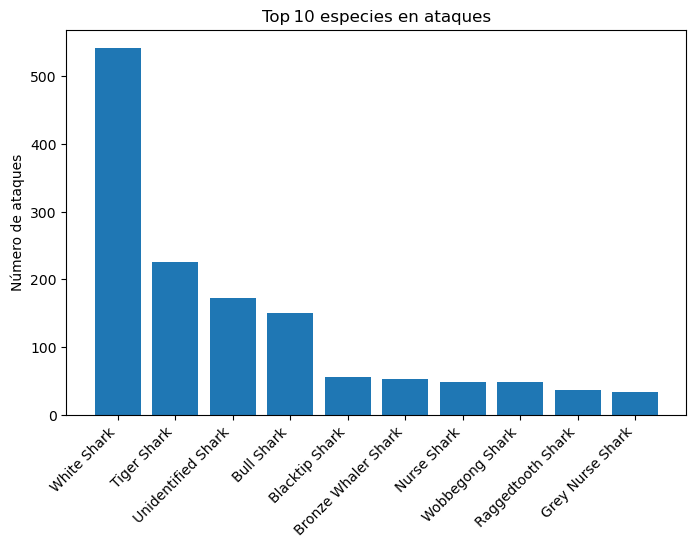

In [ ]:
#Top 10 especies en ataques

top_species = df['Species'].value_counts().nlargest(10)

plt.figure(figsize=(8,5))
plt.bar(top_species.index, top_species.values)
plt.title('Top 10 especies en ataques')
plt.ylabel('Número de ataques')
plt.xticks(rotation=45, ha='right')
plt.show()

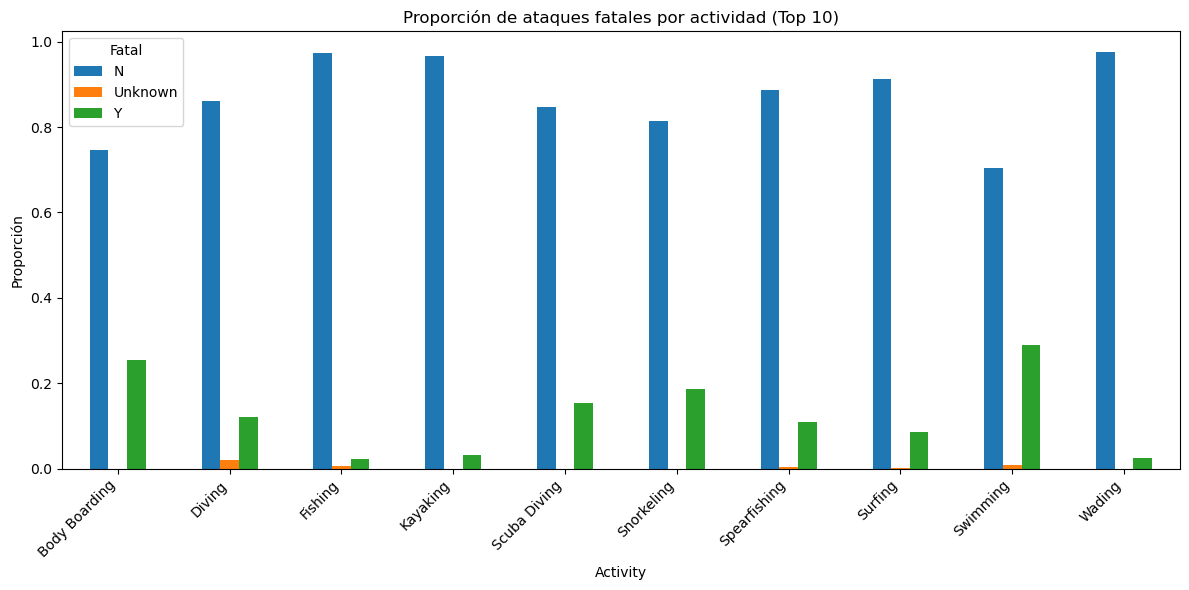

In [ ]:
# Lista de los 20 tipos de actividad más comunes

top10_activities = [
    'Surfing', 'Swimming', 'Spearfishing', 'Fishing', 'Snorkeling',
    'Body Boarding', 'Scuba Diving', 'Diving', 'Wading', 'Kayaking'
]

# Filtramos solo esas actividades
df10 = df[df['Activity'].isin(top10_activities)]

# Crosstab de actividad vs fatalidad
act_counts = pd.crosstab(df10['Activity'], df10['Fatal'])
# Convertir a proporciones por fila
act_props = act_counts.div(act_counts.sum(axis=1), axis=0)

# Barras agrupadas
act_props.plot(kind='bar', figsize=(12,6))
plt.title('Proporción de ataques fatales por actividad (Top 10)')
plt.ylabel('Proporción')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Fatal')
plt.tight_layout()
plt.show()

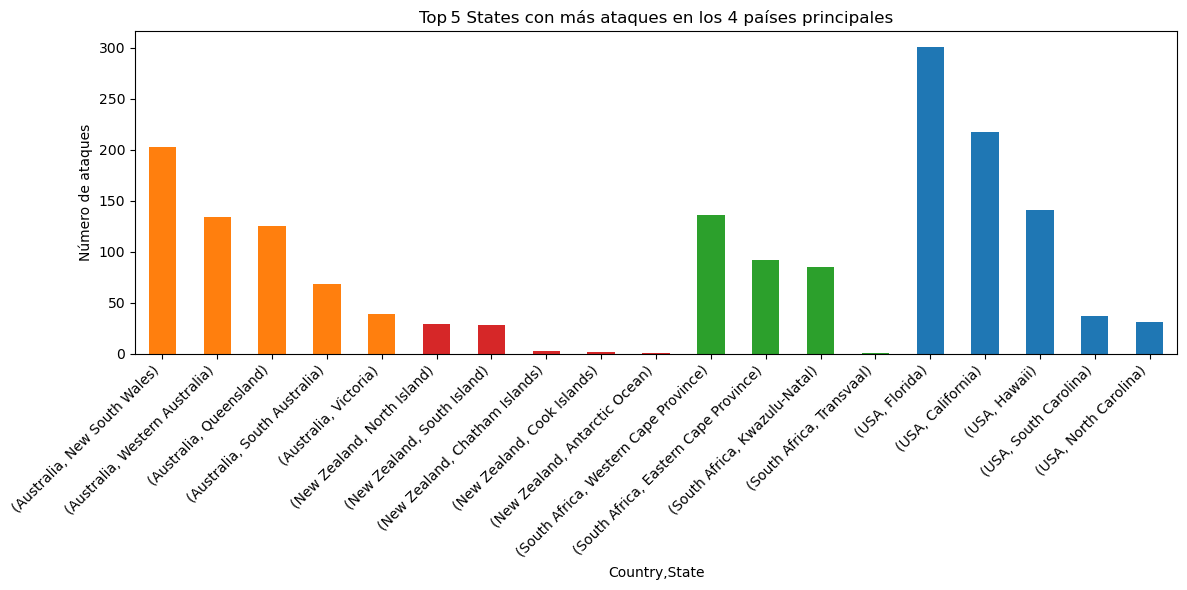

In [ ]:
#Top 5 States con más ataques en los 4 países principales

top4 = ['USA','Australia','South Africa','New Zealand']
s = (df[df['Country'].isin(top4)]
     .groupby(['Country','State'])
     .size()
     .groupby(level=0, group_keys=False)
     .nlargest(5))
# Hacemos que cada país sea de un color distinto
cmap = plt.get_cmap('tab10')
color_map = {country: cmap(i) for i, country in enumerate(top4)}
colors = [color_map[c] for c in s.index.get_level_values(0)]
# Dibujamos el bar chart con esos colores
ax = s.plot(kind='bar', figsize=(12, 6), color=colors)
plt.ylabel('Número de ataques')
plt.title('Top 5 States con más ataques en los 4 países principales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

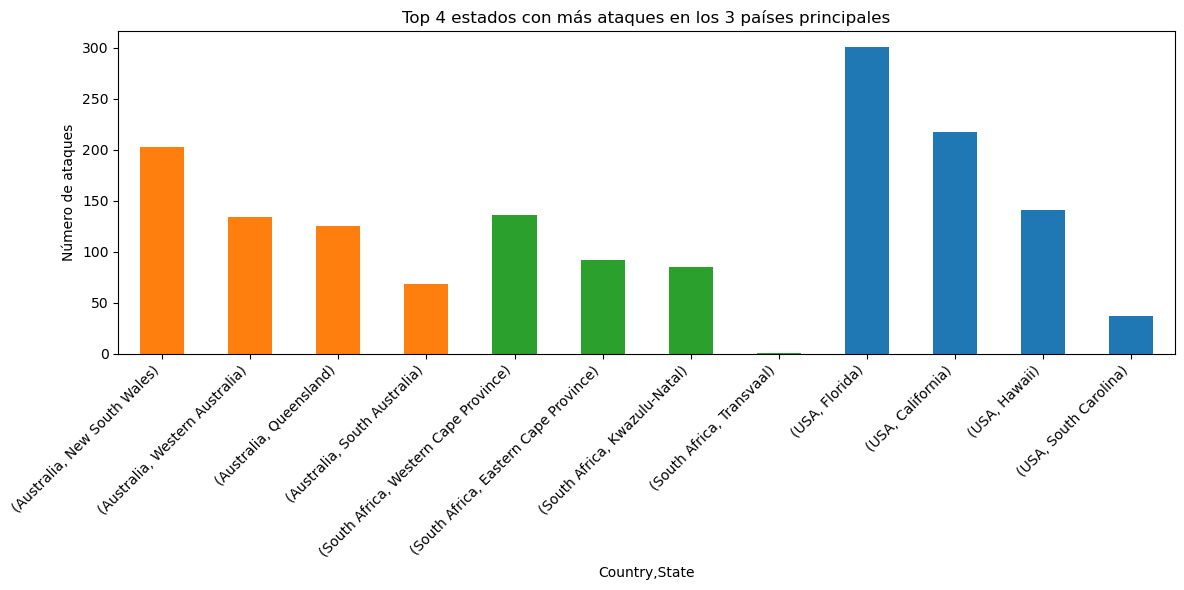

In [ ]:
#Top 5 States con más ataques en los 3 países principales

top3 = ['USA', 'Australia', 'South Africa']

s = (
    df[df['Country'].isin(top3)]
    .groupby(['Country', 'State'])
    .size()
    .groupby(level=0, group_keys=False)
    .nlargest(4)  # top 4 estados por país
)

# Asignar color distinto por país
cmap = plt.get_cmap('tab10')
color_map = {country: cmap(i) for i, country in enumerate(top3)}
colors = [color_map[c] for c in s.index.get_level_values(0)]

# Gráfico
ax = s.plot(kind='bar', figsize=(12, 6), color=colors)
plt.ylabel('Número de ataques')
plt.title('Top 4 estados con más ataques en los 3 países principales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


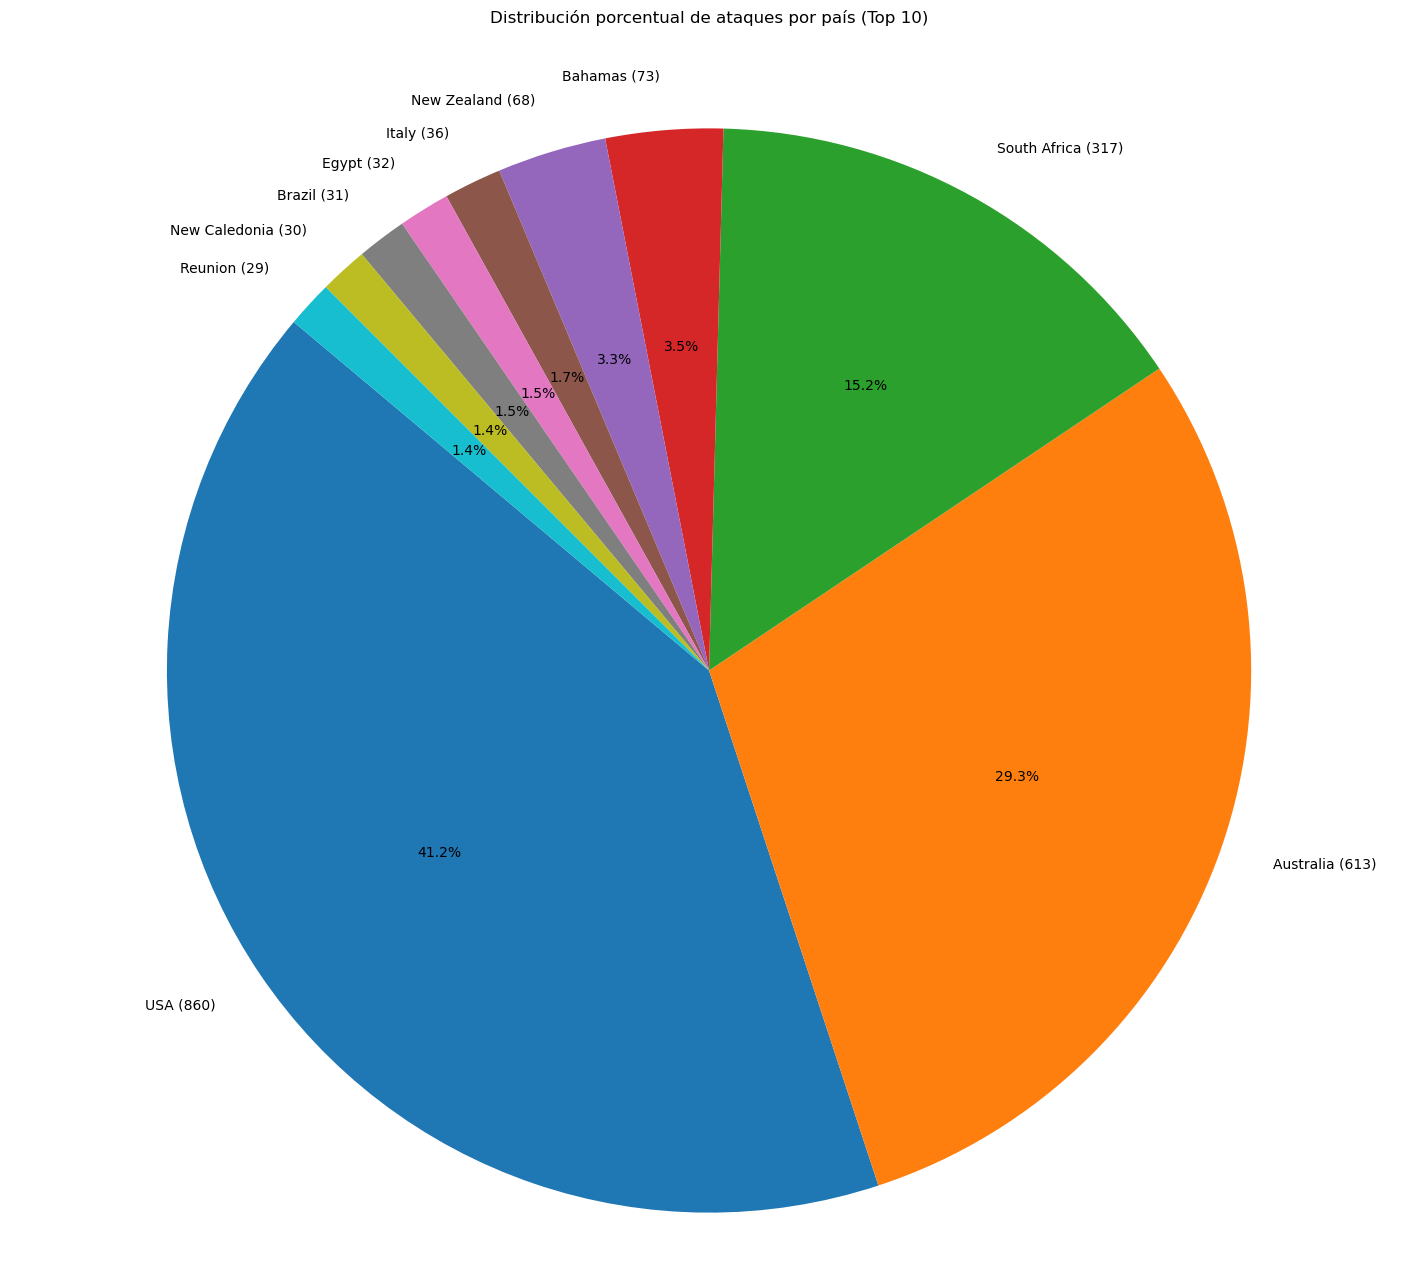

In [ ]:
# Top 10 países con más ataques

countries = df['Country'].value_counts().nlargest(10)

plt.figure(figsize=(15, 15))
plt.pie(
    countries.values,
    labels=[f"{c} ({v})" for c, v in zip(countries.index, countries.values)],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Distribución porcentual de ataques por país (Top 10)')
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(top=0.80)
plt.title('Distribución porcentual de ataques por país (Top 10)', pad=40)
plt.show()

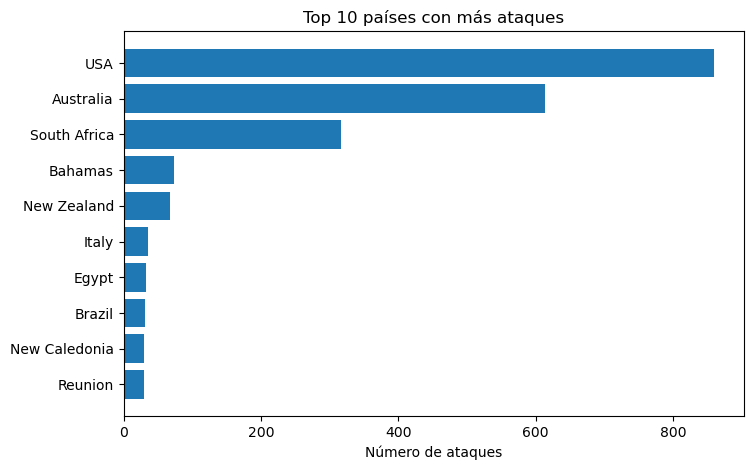

In [ ]:
# Top 10 países con más ataques

countries = df['Country'].value_counts().nlargest(10)

plt.figure(figsize=(8, 5))
plt.barh(countries.index, countries.values)
plt.title('Top 10 países con más ataques')
plt.xlabel('Número de ataques')
plt.gca().invert_yaxis()
plt.show()

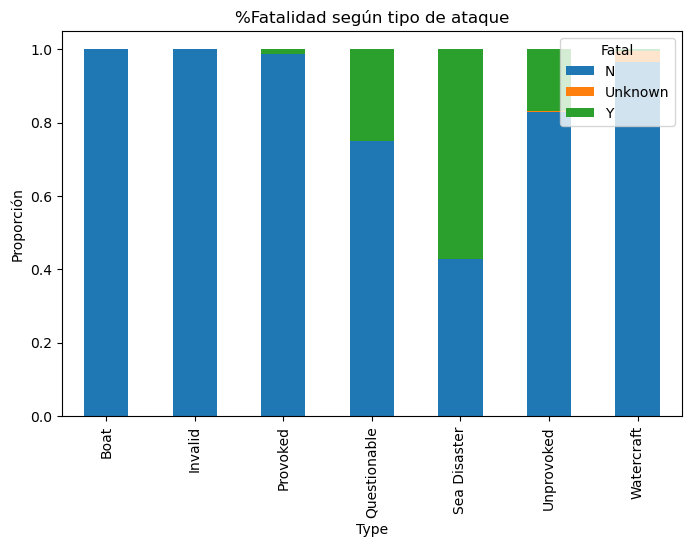

In [ ]:
#% Fatalidad según tipo de ataque

cross = pd.crosstab(df['Type'], df['Fatal'])
cross_norm = cross.div(cross.sum(axis=1), axis=0)

cross_norm.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('%Fatalidad según tipo de ataque')
plt.ylabel('Proporción')
plt.legend(title='Fatal', loc='upper right')
plt.show()

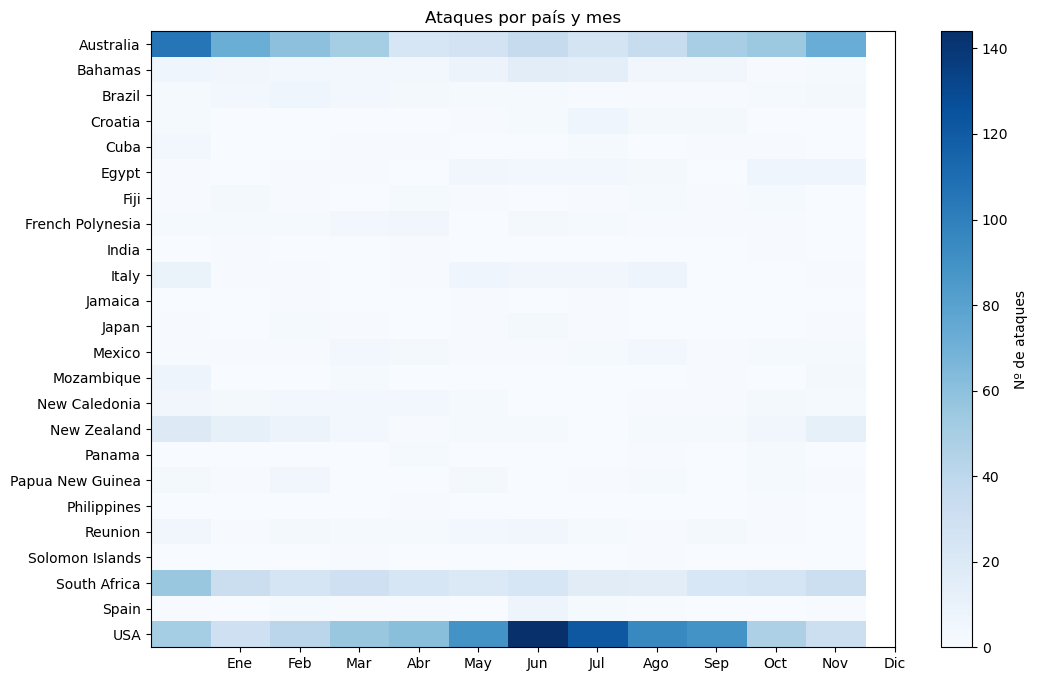

In [ ]:
# Ataques por país y mes

df['Month'] = df.index.month
heat = df.groupby(['Country','Month']).size().unstack(fill_value=0)

plt.figure(figsize=(12,8))
plt.imshow(heat, aspect='auto', cmap='Blues')
plt.colorbar(label='Nº de ataques')
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(1,13), ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
plt.title('Ataques por país y mes')
plt.show()

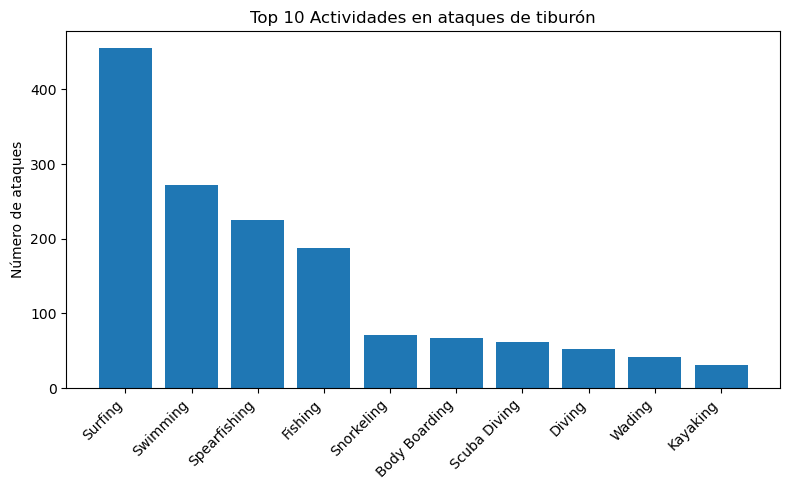

In [ ]:
# Actividades más comunes cuando ocurre un ataque

top_acts = df['Activity'].value_counts().nlargest(10)
plt.figure(figsize=(8,5))
plt.bar(top_acts.index, top_acts.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Número de ataques')
plt.title('Top 10 Actividades en ataques de tiburón')
plt.tight_layout()
plt.show()

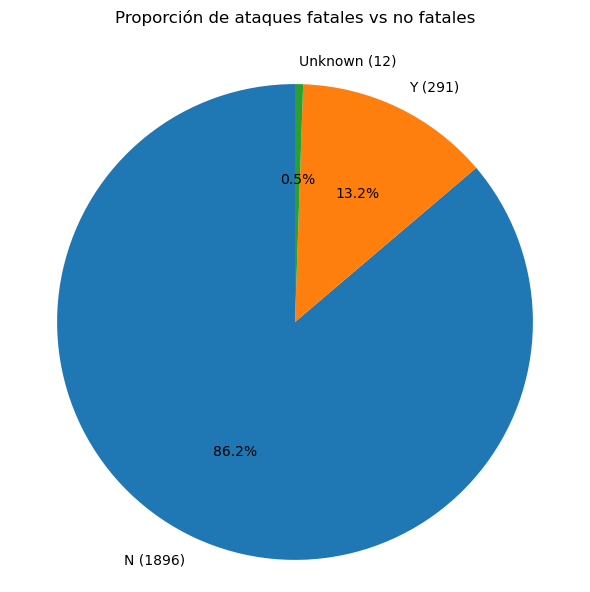

In [ ]:
# Proporcion ataques fatales vs no fatales

fatal_counts = df['Fatal'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    fatal_counts.values,
    labels=[f"{lab} ({cnt})" for lab, cnt in zip(fatal_counts.index, fatal_counts.values)],
    autopct='%1.1f%%',
    startangle=90
)
# Subimos el título
plt.title(
    'Proporción de ataques fatales vs no fatales',
    y=1.05,
    pad=10
)
plt.axis('equal')
plt.tight_layout()
plt.show()

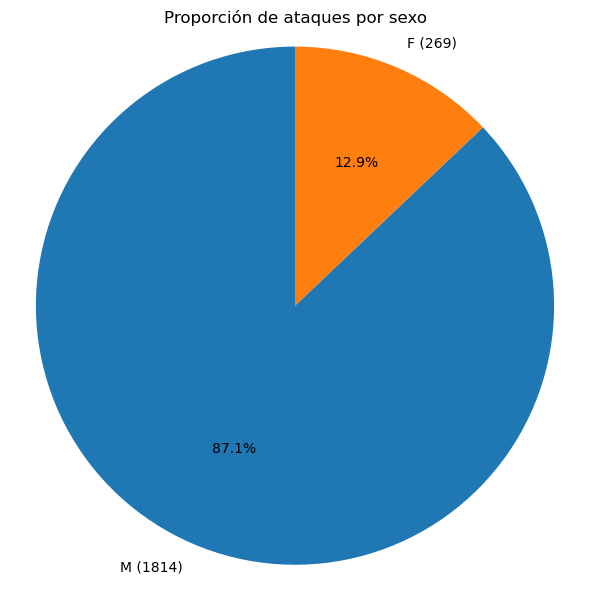

In [ ]:
# Proporción de ataques por sexo

sex_counts = df['Sex'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sex_counts.values,
        labels=[f"{lab} ({cnt})" for lab, cnt in zip(sex_counts.index, sex_counts.values)],
        autopct='%1.1f%%', startangle=90)
plt.title('Proporción de ataques por sexo')
plt.axis('equal')
plt.tight_layout()
plt.show()

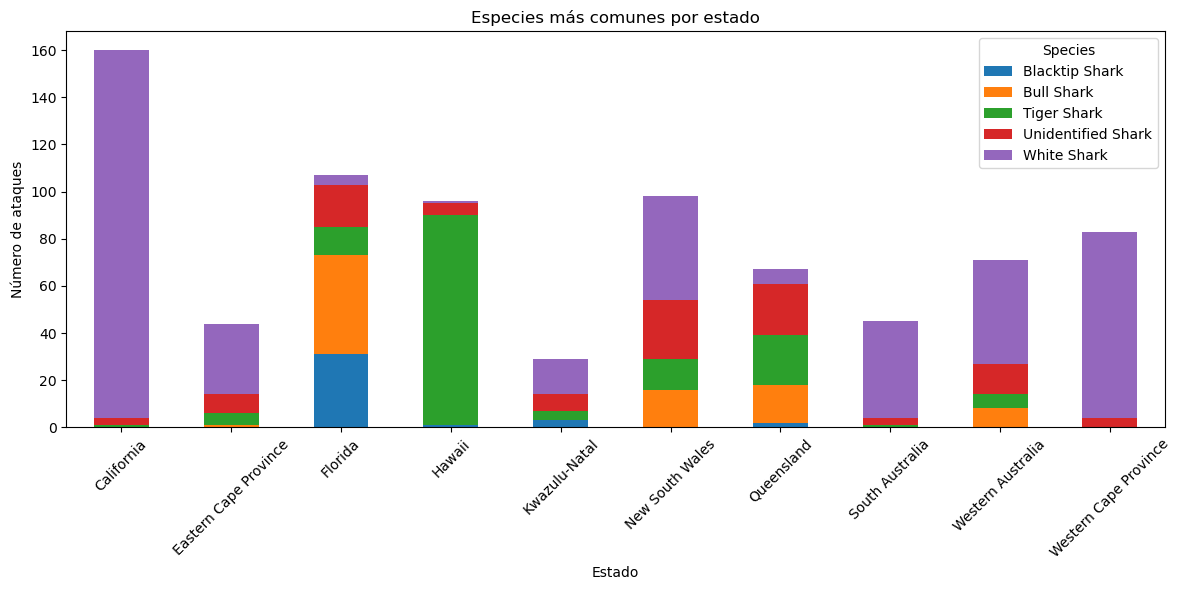

In [ ]:
#Especies más comunes por estado

top_states = df['State'].value_counts().head(10).index
top_species = df['Species'].value_counts().head(5).index

filtered_df = df[df['State'].isin(top_states) & df['Species'].isin(top_species)]
data = pd.crosstab(filtered_df['State'], filtered_df['Species'])

data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Especies más comunes por estado')
plt.xlabel('Estado')
plt.ylabel('Número de ataques')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()